In [15]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
import warnings
warnings.filterwarnings('ignore')
import cv2
# from PIL import Image
from os.path import exists
from sklearn import svm
from sklearn.metrics import accuracy_score

In [3]:
def unpickle(filepath):
    with open(filepath, 'rb') as fo:
        temp = pickle.load(fo, encoding='bytes')
        data = temp[b'data']
        labels = temp[b'labels']
    return data, labels


#Declaring the path of folder where dataset is present
img_path = "/kaggle/input/cifar10dataset/"

#Creating numpy array for storing the train data and labels
train_data = np.empty((0, 3072), int)
train_labels = np.array([])

#Loadning all the training dataset
for i in range(1, 6): 
    data_, labels_ = unpickle(img_path + "data_batch_" + str(i))
    train_data = np.append(train_data, data_, axis = 0)
    train_labels = np.append(train_labels, labels_)
    
#Loading test dataset
test_data, test_labels = unpickle(img_path + "test_batch")
test_labels = np.array(test_labels)

#printning the shape of training and test dataset and labels
print("Train data shape :", train_data.shape)
print("Test data shape :", test_data.shape)
print("Train label shape :", train_labels.shape)
print("Test label shape", test_labels.shape)

Train data shape : (50000, 3072)
Test data shape : (10000, 3072)
Train label shape : (50000,)
Test label shape (10000,)


In [4]:
type(train_data)

numpy.ndarray

In [13]:
#Storing the info of number of train and test samples, number of channels in img and height and width of image
# num_train_sample, num_channel, height, width = train_data.shape
num_train_sample = train_data.shape[0]
num_test_sample = test_data.shape[0]

#Storing the num of classes and their names 
num_classes = 10
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [14]:
#Converting the datatype of labels from float to int
train_labels = train_labels.astype(int)
test_labels = test_labels.astype(int)

In [15]:
#augmented lables
augmented_labels=np.append(train_labels,train_labels)

In [20]:
def imshow(img):
    """
    This Function is used for ploting single image.
    """
    #Transposing the image to make it fit for ploting.
    imgtranspose = np.transpose(img, (1, 2, 0))
    plt.imshow(imgtranspose)
    plt.show()
    
    
def plot_single_transformation(fun, train_data, train_labels, num = 5):
    """
    This function is used for ploting specific augmentation on images.
    """
    fig = plt.figure(figsize=(10, 3))
    idx = np.random.randint(0, num_train_sample, num)
    for i in range(num):
        fig.add_subplot(2, num, i+1)
        plt.imshow(train_data[idx][i].reshape(3,32,32).transpose(1,2,0))
        plt.axis('off')
        plt.title(classes[train_labels[idx[i]]])
#         plt.title(classes[train_labels[idx]])
        
        fig.add_subplot(2, num, i+num+1)
        plt.imshow(fun(train_data[idx][i]))
        plt.axis('off')
        plt.title(classes[train_labels[idx[i]]])
#         plt.title(classes[train_labels[idx]])
        
      
    


## Question 2 

## Image Enhancement

In [21]:
def imageEnhancement(image):
    image = image.copy()
    maxi_red = np.max(image[0:1024])
    min_red = np.min(image[0:1024])
    maxi_green = np.max(image[1024:2048])
    min_green = np.min(image[1024:2048])
    maxi_blue = np.max(image[2048:3072])
    min_blue = np.min(image[2048:3072])
    
    
    for i in range(0,1024):
        img = image[i]
        img= ((img - min_red) / (maxi_red - min_red)) * 255
        image[i]=img
    
    for i in range(1024,2048):
        img = image[i]
        img= ((img - min_green) / (maxi_green - min_green)) * 255
        image[i]=img
        
    for i in range(2048,3072):
        img = image[i]
        img= ((img - min_blue) / (maxi_blue - min_blue)) * 255
        image[i]=img
        
    image = np.reshape(image, (3, 32, 32)).transpose(1,2,0)         
    return image

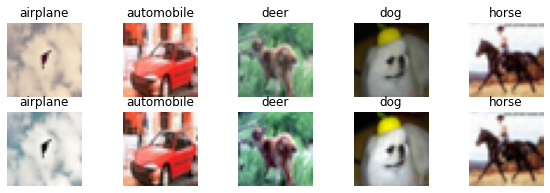

In [22]:
plot_single_transformation(imageEnhancement,train_data, train_labels, 5)


## Posterization

In [23]:
def posterization(image):
    image = np.reshape(image, (3, 32, 32)).transpose(1,2,0)
    image = image.copy()
    min_value = 100
    max_value = 200
    
    r = max_value - min_value
    
    for m in range(image.shape[0]):
        for n in range(image.shape[1]):
                divider = 255/r
                i = image[m][n]
                i = i/divider
                i = i + min_value
                image[m][n] = i
              
    return image            

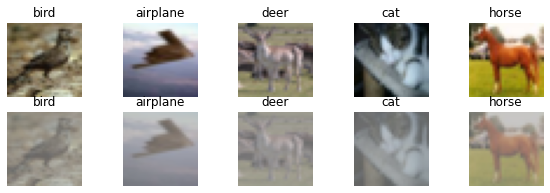

In [24]:
plot_single_transformation(posterization,train_data, train_labels, 5)

## Random Rotate

In [29]:
# function to create an image

def image_formation(image_array):
    np_image_array = np.array(image_array)
    image = image_array.reshape(3,32,32).transpose(1,2,0)
    return image

In [32]:
import math
def random_Rotate(img):
    
    image=image_formation(img)
    angle=random.uniform(-180, 180)
    # First we will convert the degrees into radians
    angle = math.radians(angle)

    # We consider the rotated image to be of the same size as the original
    rotated_image = np.uint8(np.zeros(image.shape))

    # Finding the center point of rotated (or original) image.
    rows = rotated_image.shape[0]
    cols  = rotated_image.shape[1]

    centre_x,centre_y = (cols//2, rows//2)

    for i in range(rows):
        for j in range(cols):
            x= (i-centre_x)*math.cos(angle)+(j-centre_y)*math.sin(angle)
            y= -(i-centre_x)*math.sin(angle)+(j-centre_y)*math.cos(angle)

            x=round(x)+centre_x 
            y=round(y)+centre_y 

            if (x>=0 and y>=0 and x<image.shape[0] and  y<image.shape[1]):
                rotated_image[i,j,:] = image[x,y,:]

    return rotated_image

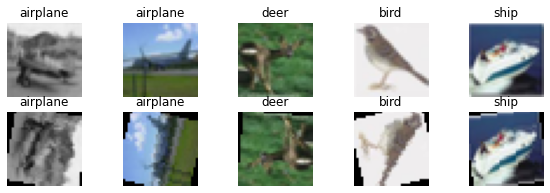

In [33]:
plot_single_transformation(random_Rotate,train_data, train_labels, 5)

## Contrast & Flip

In [36]:
def contrast_flip(image, prob = 0.5):
    image = np.reshape(image, (3, 32, 32)).transpose(1,2,0)
    image = image.copy()
    alpha = random.uniform(0.5, 2.0)
    
    image[:, :, :] = alpha * (image - 128) + 128
    
    #Cliping the image so that all the pixel values comes in the range of (0, 255)
    image[image<0] = 0
    image[image>255] = 255
    
    #Horizontally fliping the image with probability of prob which is 0.5.
    image = image[:,::-1,:] if np.random.rand() > prob else image
        
    return image


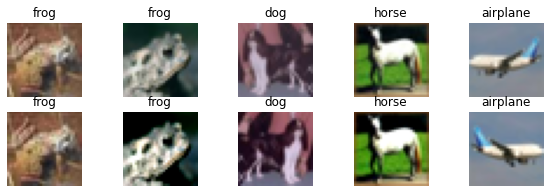

In [37]:
plot_single_transformation(contrast_flip,train_data, train_labels, 5)

# Question 3

## Data Augmentation

In [69]:
def create_augmented_data(dataset):
    augmented_data=np.empty((len(dataset)*2*3072),dtype=int)
    augmented_data=np.reshape(augmented_data,(len(dataset)*2,32,32,3))

    for i in range (len(dataset)):

        image=dataset[i]

        augmented_data[i]=np.reshape(image,(3,32,32)).transpose(1,2,0)


        choice=random.randint(1,4)

        if(choice==1):
            augmented_data[i+len(dataset)]=imageEnhancement(image)

        elif(choice==2):
            augmented_data[i+len(dataset)]=posterization(image)

        elif(choice==3):
            augmented_data[i+len(dataset)]=random_Rotate(image)

        elif(choice==4):
            augmented_data[i+len(dataset)]=contrast_flip(image)
    return augmented_data

In [60]:
augmented_labels.shape

(100000,)

In [61]:
# with open('augmented_data.pkl','wb')as file:
#     pickle.dump(augmented_data,file)

In [62]:
def resize(image):
    """
    This function will take image of any size and return resize image of size (224 X 224).
    """
    #Making copy of the image so that there is no change in original image.
    img = image.copy()
    #Calling cv2.resize function for resizing the image.
    img = np.array(img,dtype='uint8')
    img = cv2.resize(img, (224, 224))
    return img

In [63]:
def create_resized_dataset(dataset):
    """
    This funciton will take dataset of image and return the dataset containg the resized images.
    """
    num_sample = dataset.shape[0]
    resized_train_img = np.zeros((num_sample, 3, 224, 224))
    
    for i in range(num_sample):
        #Calling the resize function.
        resized_img = resize(dataset[i])
        
        #After performing the resize operation changing the image from channel last to channel first.
        resized_img = np.transpose(resized_img, (2, 0, 1))
        
        #Storing the new resized image in created sapce.
        resized_train_img[i] = resized_img
        
    return resized_train_img

In [11]:
def create_batch(img_list, label_list, batch_size = 128):
    """
    This funciton takes feature matrix and label matrix and return the list of batches of batch_size.
    """
    
    #Creating the list for storing the batches.
    batch_X = []
    batch_Y = []
    
    #Calculating the total number of batches that can be made.
    num_batches = int(np.ceil(len(img_list) / batch_size))
    for i in range(num_batches-1):
        
        #Appending all the batches in above created list.
        batch_X.append(img_list[i*batch_size:(i+1)*batch_size])
        batch_Y.append(label_list[i*batch_size:(i+1)*batch_size])
        
    #Appending the last batch into the list which may has lesser samples 
    batch_X.append(img_list[(i+1)*batch_size:])
    batch_Y.append(label_list[(i+1)*batch_size:])
    
    return batch_X, batch_Y

In [65]:
# %load /kaggle/input/featureextractor/feature_extractor.py
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision.models import resnet18

def get_name_to_module(model):
    name_to_module = {}
    for m in model.named_modules():
        name_to_module[m[0]] = m[1]
    return name_to_module


def get_activation(all_outputs, name):
    def hook(model, input, output):
        all_outputs[name] = output.detach()

    return hook


def add_hooks(model, outputs, output_layer_names):
    """
    :param model:
    :param outputs: Outputs from layers specified in `output_layer_names` will be stored in `output` variable
    :param output_layer_names:
    :return:
    """
    name_to_module = get_name_to_module(model)
    for output_layer_name in output_layer_names:
        name_to_module[output_layer_name].register_forward_hook(get_activation(outputs, output_layer_name))


class ModelWrapper(nn.Module):
    def __init__(self, model, output_layer_names, return_single=True):
        super(ModelWrapper, self).__init__()
        
        self.model = model
        self.output_layer_names = output_layer_names
        self.outputs = {}
        self.return_single = return_single
        add_hooks(self.model, self.outputs, self.output_layer_names)

    def forward(self, images):
        self.model(images)
        output_vals = [self.outputs[output_layer_name] for output_layer_name in self.output_layer_names]
        if self.return_single:
            return output_vals[0]
        else:
            return output_vals

class BBResNet18(object):
    def __init__(self):
        self.model = resnet18(pretrained=False)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.model.eval()

        self.model = ModelWrapper(self.model, ['avgpool'], True)

        self.model.eval()
        self.model.to(self.device)

    def feature_extraction(self, x:np.ndarray):
        '''
            param:
                x: numpy ndarray of shape: [None, 3, 224, 224] and dtype: np.float32
            
            return:
                numpy ndarray (feature vector) of shape: [None, 512] and dtype: np.float32
        '''
        
        x = torch.from_numpy(x).to(self.device)
        
        with torch.no_grad():
            out = self.model(x).cpu().detach()
            out = out.view(out.size(0), -1)
            out = out.numpy()

        return out

In [66]:
obj = BBResNet18()

In [67]:
def create_data_feature(obj, dataset, labels):
    
    """
    This funciton takes dataset, label, and BBResNet18 object as arguments and return the extracted feature from BBResNet18
    class.
    """
    
    #Creating batch of dataset and labels.
    batch_X, batch_Y = create_batch(dataset, labels, 64)
    
    #Creating list for storing feature.
    data_feature = []
    
    #Looping over each epoch.
    for inputs in batch_X:
        
        #Resizing the dataset acording to BBResNet18 input size.
        resized_inputs = create_resized_dataset(inputs)
        
        #Passing the resized dataset into BBResNet18 for feature extraction.
        #Performing "Normalization" by dividing image by 255 for fast computation and better accuracy.
        #Changing the datatype of image from int to flaot32 according to BBResNet18.
        batch_features = obj.feature_extraction((resized_inputs/255).astype('float32'))
        
        #Extending the data feature of current batch into the list 
        data_feature.extend(batch_features)
    
    #Converting the data_feature to numpy array.
    data_feature = np.array(data_feature)
    
    return data_feature

In [ ]:
test_augmented_data = create_augmented_data(test_data)

In [ ]:
# train_aug_labels = augmented_labels
# test_aug_labels = test_labels

In [52]:
#Extracting data feature for augmented dataset and storing it in featureVector.
train_feature_vector = create_data_feature(obj, augmented_data, augmented_labels)
    
#Extracting data feature for test dataset and storing it in test_data_feature.
test_feature_vector = create_data_feature(obj, test_augmented_data, test_aug_labels)
    

# Saving our train and test set in pkl files

In [55]:
with open('train_feature_vector.pkl', 'wb') as file:
    pickle.dump(train_feature_vector, file)
    
with open('train_labels.pkl', 'wb') as file:
    pickle.dump(train_labels, file)
    
with open('test_feature_vector.pkl', 'wb') as file:
    pickle.dump(test_feature_vector, file)
    
with open('test_labels.pkl', 'wb') as file:
    pickle.dump(test_aug_labels, file)

# Creating pickle files of Training and Test Set
# (Last Section)
* Execute from here

In [16]:
file1 = open('train_feature_vector.pkl', 'rb')
train_feature_vector = pickle.load(file1)

file2 = open("train_labels.pkl", "rb")
train_aug_labels = pickle.load(file2)

file3 = open("test_feature_vector.pkl", "rb")
test_feature_vector = pickle.load(file3)

file4 = open("test_labels.pkl", "rb")
test_aug_labels = pickle.load(file4)

In [17]:
#Creating one hot vector of labels for train and test set
num_classes = 10
one_hot_train_label = np.zeros((len(train_aug_labels), num_classes))
one_hot_test_label = np.zeros((len(test_aug_labels), num_classes))

for i in range(len(train_aug_labels)):
    one_hot_train_label[i, train_aug_labels[i]] = 1

for i in range(len(test_aug_labels)):
    one_hot_test_label[i, test_aug_labels[i]] = 1

In [18]:
def create_batch(img_list, label_list, batch_size = 128):
    """
    This funciton takes feature matrix and label matrix and return the list of batches of batch_size.
    """
    
    #Creating the list for storing the batches.
    batch_X = []
    batch_Y = []
    
    #Calculating the total number of batches that can be made.
    num_batches = int(np.ceil(len(img_list) / batch_size))
    for i in range(num_batches-1):
        
        #Appending all the batches in above created list.
        batch_X.append(img_list[i*batch_size:(i+1)*batch_size])
        batch_Y.append(label_list[i*batch_size:(i+1)*batch_size])
        
    #Appending the last batch into the list which may has lesser samples 
    batch_X.append(img_list[(i+1)*batch_size:])
    batch_Y.append(label_list[(i+1)*batch_size:])
    
    return batch_X, batch_Y

In [19]:
class MLP:
    
        def __init__(self, X, Y, X_test, Y_test, lr_rate = 0.01, batch_size = 64, epochs = 200):
           
            np.random.seed(0)
            self.input_size = 512
            self.hidden1_size = 64
            self.hidden2_size = 64
            self.output_size = 10

            self.total_sample = X.shape[0]

            self.w1 = np.random.random((self.input_size, self.hidden1_size))/(1e3)
            self.b1 = np.zeros((self.hidden1_size))
            self.w2 = np.random.random((self.hidden1_size, self.hidden2_size))/(1e3)
            self.b2 = np.zeros((self.hidden2_size))
            self.w3 = np.random.random((self.hidden2_size, self.output_size))/(1e3)
            self.b3 = np.zeros((self.output_size))



            #Initializing and storing gradient.
            self.dw3 = None
            self.db3 = None
            self.dw2 = None
            self.db2 = None
            self.dw1 = None
            self.db1 = None

            #Initializing and storing Intermidiate result of forward pass.
            self.z1 = None
            self.a1 = None
            self.z2 = None
            self.a2 = None
            self.z3 = None
            self.a3 = None

            #Initializing learning rate, batch size and number of epochs
            self.lr_rate = lr_rate
            self.batch_size = batch_size
            self.epochs = epochs

            #Initializing feature matrix and label matrix
            self.data = X
            self.labels = Y
            self.X_test = X_test
            self.Y_test = Y_test

            #For storing training loss and accuracy for each epoch.
            self.training_loss = []
            self.training_acc = []
            self.test_loss= []
            self.test_acc = []


        
        def relu(self, X):
            return np.maximum(X, 0)
        
        def softmax(self, X):
            return np.exp(X) / np.sum(np.exp(X), axis=1).reshape(X.shape[0], 1)
        
        def loss_function(self, y_hat, y):
            return -np.sum(y * np.log(y_hat)) / len(y)
    
        def accuracy(self, y_hat, y):
            return (np.argmax(y, axis = 1) == np.argmax(y_hat, axis=1)).mean()
        
        
        def forward_pass(self, inputs):
            self.z1 = np.matmul(inputs, self.w1) + self.b1
            self.a1 = self.relu(self.z1)
            self.z2 = np.matmul(self.a1, self.w2) + self.b2
            self.a2 = self.relu(self.z2)
            self.z3 = np.matmul(self.a2, self.w3) + self.b3
            self.a3 = self.softmax(self.z3)
        
        def relu_gradient(self, x):
            return (x > 0) * 1
    
    
        def backward_pass(self, inputs, labels):

            sample_size = inputs.shape[0]                        
            
            dz3 = self.a3 - labels                              
            self.dw3 = np.dot(self.a2.T, dz3) / sample_size      
            self.db3 = np.sum(dz3, axis = 0) / sample_size       

            self.a2[self.a2>0] = 1                               
            g1 = self.a2
            
            dz2 = np.dot(dz3, self.w3.T) * g1                    
            self.dw2 = np.dot(self.a1.T, dz2) / sample_size       
            self.db2 = np.sum(dz2, axis = 0) / sample_size
            
            
            self.a1[self.a1>0] = 1                               
            g0 = self.a1

            dz1 = np.dot(dz2, self.w2.T) * g0                    
            self.dw1 = np.dot(inputs.T, dz1) / sample_size       
            self.db1 = np.sum(dz1, axis = 0) / sample_size       

        
           
        def gradient_descent(self):
            self.w3 = self.w3 - self.lr_rate * self.dw3
            self.b3 = self.b3 - self.lr_rate * self.db3
            self.w2 = self.w2 - self.lr_rate * self.dw2
            self.b2 = self.b2 - self.lr_rate * self.db2
            self.w1 = self.w1 - self.lr_rate * self.dw1
            self.b1 = self.b1 - self.lr_rate * self.db1

            
            
        def train(self):

            #Creating mini batches of data for training.
            batch_X, batch_Y = create_batch(self.data, self.labels, self.batch_size)

            num_batches = len(batch_X)                             #Storing the number of batchs.

            for epoch in range(self.epochs):                       #Iterating over each epoch.

                running_loss = 0                                   #For storing total training loss occured in an epoch.
                running_acc = 0                                    #For storing total training accuracy on current epoch. 

                for itr in range(num_batches):                     #Looping over each batch.

                    inputs, labels = batch_X[itr], batch_Y[itr]    #Defining inputs and labels for current batch.

                    num_sample = inputs.shape[0]                   #Storing total number of sample in current batch.

                    self.forward_pass(inputs)                      #Performing forward pass for current iteration.

                    self.backward_pass(inputs, labels)             #Performing backward pass for current iteration.

                    self.gradient_descent()                        #Performing gradient descent for current iteration.

                    
                    loss = self.loss_function(self.a3, labels)     #Calculating loss for current iteration.
                    acc = self.accuracy(self.a3, labels)           #Calculating accuracy for iteration. 

                    running_acc += acc*num_sample                  #Adding current batch loss and accuracy. Multiplying it batch
                    running_loss += loss*num_sample                #size because acc and loss are mean of the current batches.

                epoch_loss = running_loss/self.total_sample        #Calculating average training loss and accuaracy by dividing
                epoch_acc = running_acc/self.total_sample          #it by total number of sample.

                self.training_acc.append(epoch_acc*100)            #Appending training accuracy and loss
                self.training_loss.append(epoch_loss) 

                test_l, test_a = self.evaluate()                   #Checking the loss and accuracy after training for every epoch.
                                                                   #on test dataset.
                self.test_acc.append(test_a)                       #Appending loss and accuracy of test dataset.
                self.test_loss.append(test_l)

                #Printing status of training after every 10 epochs.
                if epoch == 0 or (epoch + 1)%10 == 0 or epoch == self.epochs - 1:
                    print("Epoch : {:d}, Training Loss : {:.3f}, Training Accuracy : {:.3f} ".format(epoch + 1, epoch_loss, epoch_acc*100))

                    
        def predict(self, X):
            self.forward_pass(X)                       
            return np.argmax(self.output, axis = 1)        

        
        def evaluate(self, Print = False):
            self.forward_pass(self.X_test)                            
            acc = self.accuracy(self.a3, self.Y_test)                 
            loss = self.loss_function(self.a3, self.Y_test)           

            if Print:
                print("Loss : {:.3f}, Accuracy : {:.3f}".format(loss, acc*100))
                return 

            return loss, acc

In [20]:
unaugmented_model = MLP(train_feature_vector[:50000], one_hot_train_label[:50000], 
                        test_feature_vector[:10000], one_hot_test_label[:10000], 
                        lr_rate = 0.01, batch_size = 32, epochs = 100)
unaugmented_model.train()

Epoch : 1, Training Loss : 2.303, Training Accuracy : 9.756 
Epoch : 10, Training Loss : 1.556, Training Accuracy : 32.934 
Epoch : 20, Training Loss : 0.715, Training Accuracy : 75.218 
Epoch : 30, Training Loss : 0.577, Training Accuracy : 79.822 
Epoch : 40, Training Loss : 0.519, Training Accuracy : 81.896 
Epoch : 50, Training Loss : 0.476, Training Accuracy : 83.298 
Epoch : 60, Training Loss : 0.440, Training Accuracy : 84.632 
Epoch : 70, Training Loss : 0.408, Training Accuracy : 85.684 
Epoch : 80, Training Loss : 0.380, Training Accuracy : 86.674 
Epoch : 90, Training Loss : 0.355, Training Accuracy : 87.574 
Epoch : 100, Training Loss : 0.333, Training Accuracy : 88.474 


In [17]:
unaugmented_model.evaluate(Print = True)

Loss : 0.818, Accuracy : 77.220


In [13]:
augmented_model = MLP(train_feature_vector, one_hot_train_label,
                     test_feature_vector, one_hot_test_label,
                     lr_rate = 0.01, batch_size = 32, epochs = 40)
augmented_model.train()

Epoch : 1, Training Loss : 2.303, Training Accuracy : 9.633 
Epoch : 10, Training Loss : 0.921, Training Accuracy : 67.678 
Epoch : 20, Training Loss : 0.676, Training Accuracy : 75.976 
Epoch : 30, Training Loss : 0.606, Training Accuracy : 78.557 
Epoch : 40, Training Loss : 0.561, Training Accuracy : 80.076 


In [14]:
augmented_model.evaluate(Print = True)

Loss : 0.804, Accuracy : 72.780


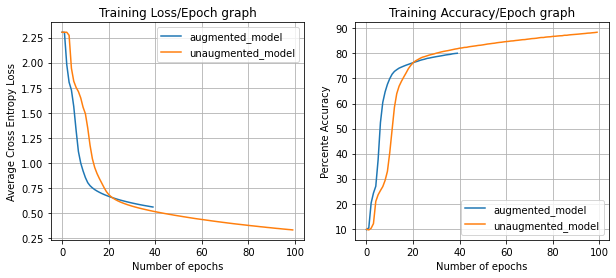

In [19]:
fig = plt.figure(figsize=(10, 4))
fig.add_subplot(1, 2, 1)
plt.plot(augmented_model.training_loss, label = 'augmented_model')
plt.plot(unaugmented_model.training_loss, label = 'unaugmented_model')
plt.grid()
plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Average Cross Entropy Loss")
plt.title("Training Loss/Epoch graph")

#Ploting Accuracy per epoch graph.
fig.add_subplot(1, 2, 2)
plt.plot(augmented_model.training_acc, label = 'augmented_model')
plt.plot(unaugmented_model.training_acc, label = 'unaugmented_model')
plt.grid()
plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Percente Accuracy")
plt.title("Training Accuracy/Epoch graph")
plt.show()

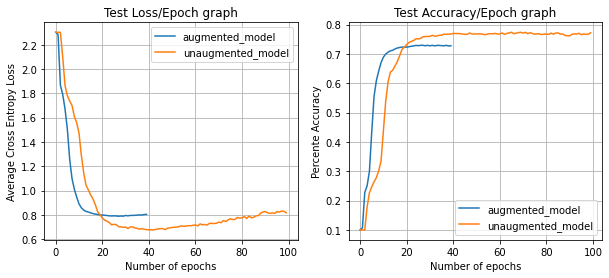

In [20]:
fig = plt.figure(figsize=(10, 4))
fig.add_subplot(1, 2, 1)
plt.plot(augmented_model.test_loss, label = 'augmented_model')
plt.plot(unaugmented_model.test_loss, label = 'unaugmented_model')
plt.grid()
plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Average Cross Entropy Loss")
plt.title("Test Loss/Epoch graph")

#Ploting Accuracy per epoch graph.
fig.add_subplot(1, 2, 2)
plt.plot(augmented_model.test_acc, label = 'augmented_model')
plt.plot(unaugmented_model.test_acc, label = 'unaugmented_model')
plt.grid()
plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Percente Accuracy")
plt.title("Test Accuracy/Epoch graph")
plt.show()

## SVM

In [21]:
# Train the SVM on the training data
clf = svm.LinearSVC() 
clf.fit(train_feature_vector, train_aug_labels)

# Predict on the test data
predictions = clf.predict(test_feature_vector)

# Evaluate the accuracy of the predictions
accuracy = accuracy_score(test_aug_labels, predictions)
print('SVM Accuracy on Augmented data:', accuracy)

SVM Accuracy on Augmented data: 0.6675


In [22]:
clf = svm.LinearSVC() 
clf.fit(train_feature_vector[:50000], train_aug_labels[:50000])

# Predict on the test data
predictions = clf.predict(test_feature_vector[:10000])

# Evaluate the accuracy of the predictions
accuracy = accuracy_score(test_aug_labels[:10000], predictions)
print('SVM Accuracy on unaugmented data:', accuracy)

SVM Accuracy on unaugmented data: 0.7675


## Decision Tree Classifier

In [23]:
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(max_depth =12, random_state = 42)
classifier.fit(train_feature_vector, train_aug_labels)

predictions = classifier.predict(test_feature_vector)

# Evaluate the accuracy of the predictions
accuracy = accuracy_score(test_aug_labels, predictions)
print('DTC Accuracy on Augmented data:', accuracy)

DTC Accuracy on Augmented data: 0.44345


In [24]:
classifier = DecisionTreeClassifier(max_depth =12, random_state = 42)
classifier.fit(train_feature_vector[:50000], train_aug_labels[:50000])

predictions = classifier.predict(test_feature_vector[:10000])

# Evaluate the accuracy of the predictions
accuracy = accuracy_score(test_aug_labels[:10000], predictions)
print('DTC Accuracy on unaugmented data:', accuracy)

DTC Accuracy on unaugmented data: 0.4846


## Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state=42,multi_class='ovr',max_iter =1000)
classifier.fit(train_feature_vector,train_aug_labels)

predictions = classifier.predict(test_feature_vector)

# Evaluate the accuracy of the predictions
accuracy = accuracy_score(test_aug_labels, predictions)
print('LR Accuracy on Augmented data:', accuracy)

LR Accuracy on Augmented data: 0.7142


In [26]:
classifier = LogisticRegression(random_state=42,multi_class='ovr',max_iter =1000)
classifier.fit(train_feature_vector[:50000],train_aug_labels[:50000])

predictions = classifier.predict(test_feature_vector[:10000])

# Evaluate the accuracy of the predictions
accuracy = accuracy_score(test_aug_labels[:10000], predictions)
print('LR Accuracy on Unaugmented data:', accuracy)

LR Accuracy on Unaugmented data: 0.7864


## KNN Classifier

In [35]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier()
classifier.fit(train_feature_vector, train_aug_labels)
predictions = classifier.predict(test_feature_vector)

accuracy = accuracy_score(test_aug_labels, predictions)
print('KNN Accuracy on Augmented Data:', accuracy)

KNN Accuracy on Augmented Data: 0.6216


In [36]:
classifier = KNeighborsClassifier()
classifier.fit(train_feature_vector[:50000], train_aug_labels[:50000])
predictions = classifier.predict(test_feature_vector[:10000])

accuracy = accuracy_score(test_aug_labels[:10000], predictions)
print('KNN Accuracy on Unaugmented Data:', accuracy)

KNN Accuracy on Unaugmented Data: 0.6938


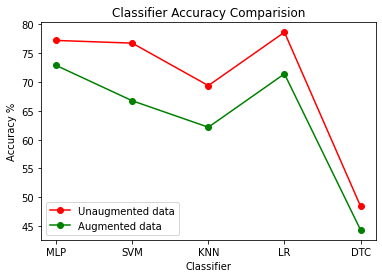

In [7]:
classifiers = ['MLP','SVM', 'KNN', 'LR', 'DTC']
unaug_accuracy = [77.22, 76.75, 69.38, 78.64, 48.46]
aug_accuracy = [72.88, 66.75, 62.16, 71.42, 44.34]

plt.plot( classifiers,unaug_accuracy, color='r',marker = 'o', label='Unaugmented data')
plt.plot( classifiers,aug_accuracy, color='g', marker = 'o', label='Augmented data')
  
# Naming the x-axis, y-axis and the whole graph
plt.ylabel("Accuracy %")
plt.xlabel("Classifier")
plt.title("Classifier Accuracy Comparision")
# plt.ylim(0, 100)
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()